<a href="https://colab.research.google.com/github/mag381/AI/blob/main/11_LSTM_timeseries_weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

# Timeseries forecasting for weather prediction

**Authors:** [Prabhanshu Attri](https://prabhanshu.com/github), [Yashika Sharma](https://github.com/yashika51), [Kristi Takach](https://github.com/ktakattack), [Falak Shah](https://github.com/falaktheoptimist)<br>
**Date created:** 2020/06/23<br>
**Last modified:** 2020/07/20<br>
**Description:** This notebook demonstrates how to do timeseries forecasting using a LSTM model.

## Setup
This example requires TensorFlow 2.3 or higher.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [21]:
from zipfile import ZipFile
import os
# ウェブからzipファイルのURLを設定
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
# URLのファイルを取り込み
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")


In [22]:
# zip ファイルをcolaboratory上で解凍
# 左欄に解凍されたファイルが表示される
zip_file = ZipFile(zip_path)
zip_file.extractall()

In [23]:
# 解凍されたファイルの名前をセット
# pandas で　csvファイルを読み込み
# データを変数 df の DataFrame に格納
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

In [24]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

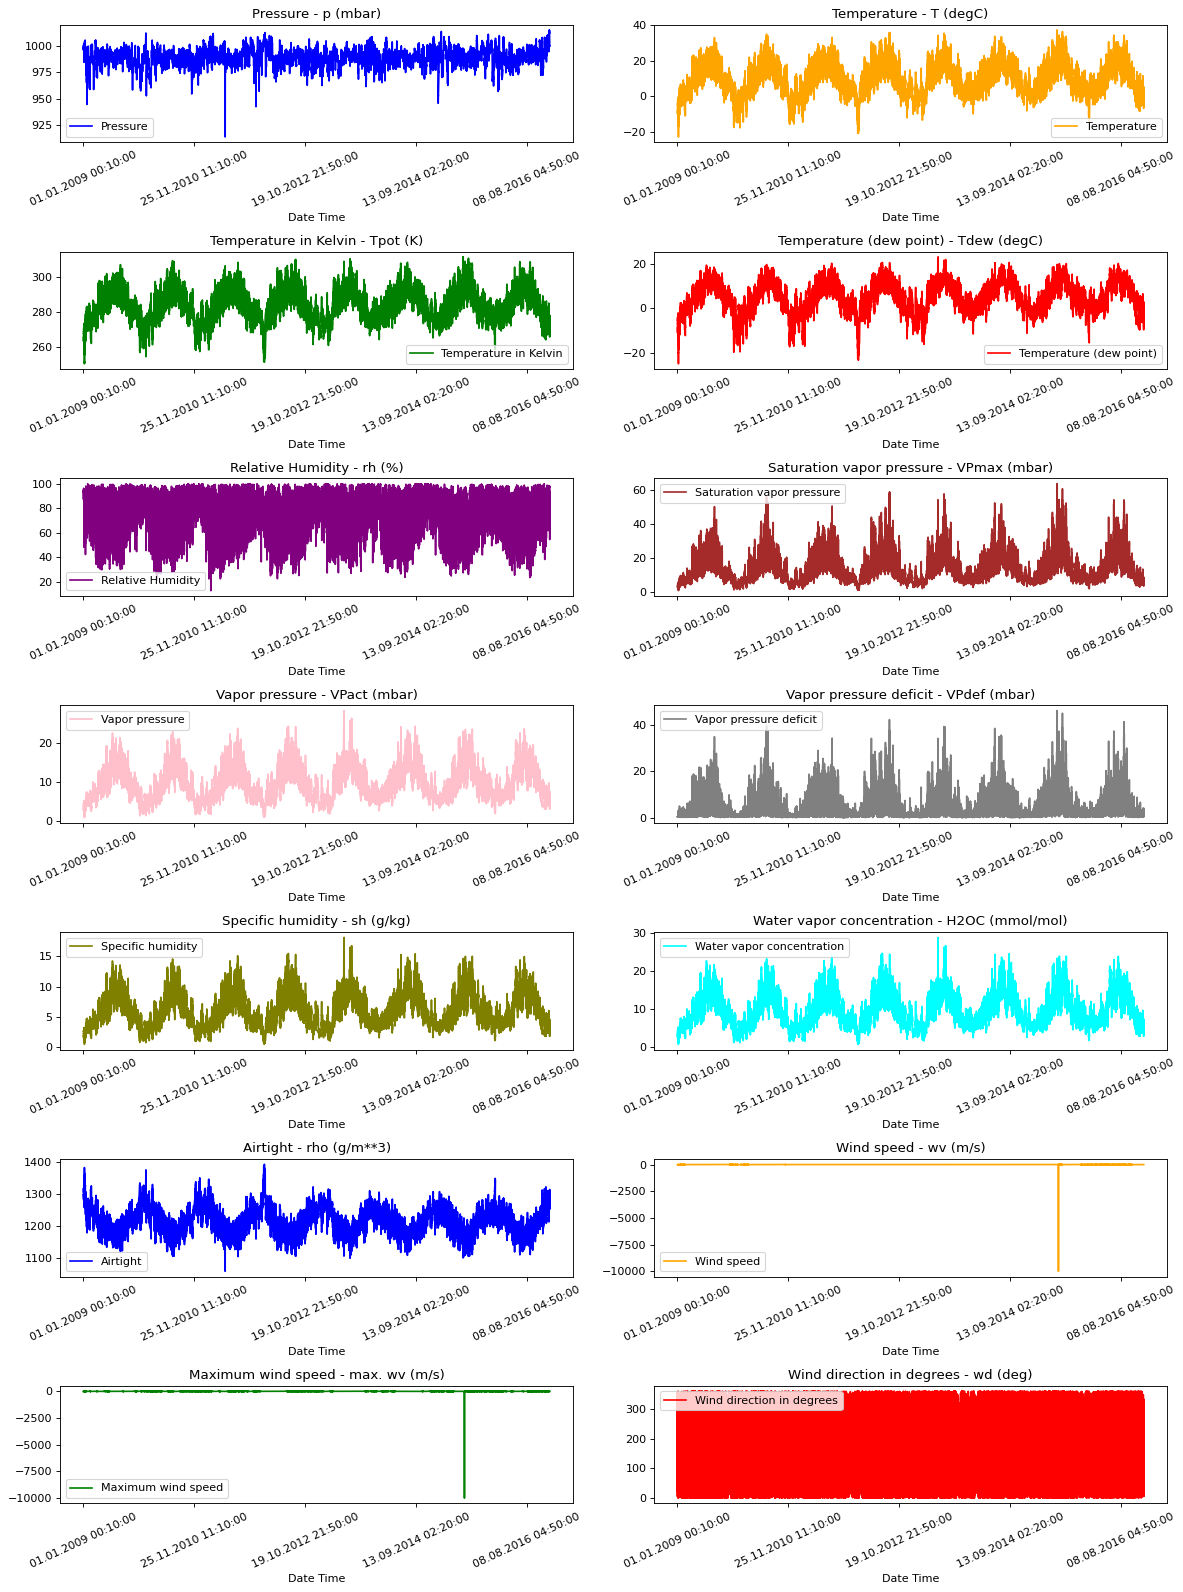

In [25]:
# 関数の定義（引数はDataFrameで、変数名 data）

def show_raw_visualization(data):
    # "Date Time" のデータを time_data にコピー
    time_data = data[date_time_key]
    # 7行に渡ってグラフをプロットする準備
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    # "p (mbar)",... "wd (deg)" を順番に取り出す
    # feature_keysの数だけ for 文を繰り返す
    for i in range(len(feature_keys)):
        # i番目のfeature_keysを変数 key に代入
        key = feature_keys[i]
        # i番目の色を変数 c に代入
        c = colors[i % (len(colors))]
        # DataFrame の key の数値を t_data に代入
        t_data = data[key]
        # t_data のインデックスは time_data を使う
        t_data.index = time_data
        # t_data の最初の5行を表示
        t_data.head()
        # i番目の図の軸を設定
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        # i番目のタイトルを設定
        ax.legend([titles[i]])
    plt.tight_layout()

# 上で定義した関数を呼び出す
show_raw_visualization(df)

This heat map shows the correlation between different features.

<ipython-input-26-e2e345d374fc>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


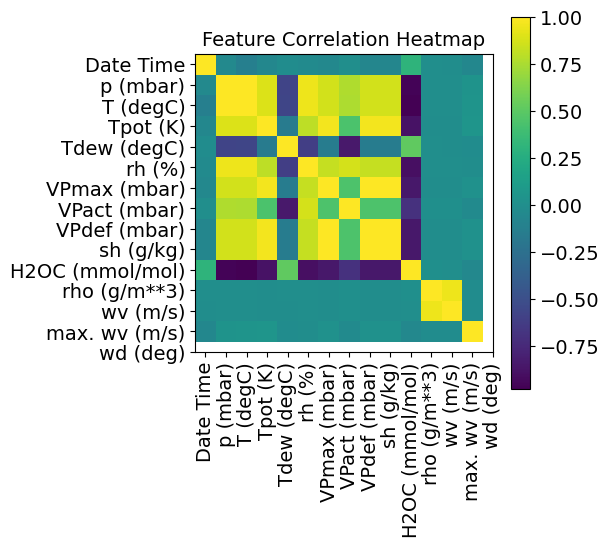

In [26]:
# ヒートマップを表示する関数を定義する
# 引数は DataFrame
def show_heatmap(data):
    # マトリックス状に相関をプロットする
    plt.matshow(data.corr())
    # x軸の設定（文字を90度回転させて表示）
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    # y軸の設定
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    # カラーバーを変数cbにセット
    cb = plt.colorbar()
    # カラーバーの数字のサイズを設定
    cb.ax.tick_params(labelsize=14)
    # 図のタイトルを設定
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

# 上で定義した関数を呼び出す
show_heatmap(df)


## Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (72/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [27]:
# 全体の71.5%を訓練データに割り当てる
split_fraction = 0.715
# 全体のデータ数✕比率を訓練データ数とする
train_split = int(split_fraction * int(df.shape[0]))
# 10分毎のデータではなく、60分毎のデータを使う
step = 6
# 過去720個のデータを使う（720✕10分＝7200分=120時間）
past = 720
# 未来72個先を予測する（72✕10分=720分=12時間）
future = 72
# 学習率
learning_rate = 0.001
batch_size = 256
epochs = 10

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [28]:
# 使用するパラメータを表示する
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
# 指定した番号の項目を 変数に代入
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
# 指定した項目のデータを変数 features にコピー
features = df[selected_features]
# 変数 features の index に
# date_time_key = "Date Time" を設定する
features.index = df[date_time_key]
# 最初の5行を表示
features.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [29]:
# データを標準化する関数を定義する
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

# 上で定義した標準化処理をfeaturesの値に適用
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [30]:
# features の値を訓練データ、検証データに代入
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [31]:
# 過去720個のデータを使う（720✕10分＝7200分=120時間）
# 未来72個先を予測する（72✕10分=720分=12時間）

start = past + future
end = start + train_split

# 列番号0から7の訓練データの値を x_train に代入
# 変数 features の データを y_train に代入

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

# 過去720個のデータを6ステップ毎につかうと、120個になる
sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [32]:
# データ前処理したものを dataset_train に代入
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [33]:
# 検証データの数－720個－72個が終わりの位置
x_end = len(val_data) - past - future

# 訓練データの数＋720個＋72個を label_startにセット
label_start = train_split + past + future

# 列番号 0～7 の検証データの値を x_val に代入
# features のデータの値を y_val に代入
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

# データ前処理したものを dataset_val に代入
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [34]:
# 訓練データから入力値と答えを取り出して
# inputs と targets に代入
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


## Training

In [35]:
# モデルの構造を設定（LSTMを利用）
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)

# 設定した構造のモデルを実行可能な形式に変換（コンパイル）
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
# 変換したモデルの構造を表示
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                5120      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [36]:
# チェックポイントを定期的に保存するために
# ModelCheckpoint を使い、
# 検証ロスが改善しなくなったら訓練を中断する

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# fit で訓練を実行し、学習履歴をhistory に保存する
# 原典通りの epochs=10 で 12分程度かかる
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
1171/1172 [============================>.] - ETA: 0s - loss: 0.1823
Epoch 1: val_loss improved from inf to 0.14677, saving model to model_checkpoint.h5
1172/1172 [==============================] - 68s 56ms/step - loss: 0.1823 - val_loss: 0.1468
Epoch 2/20
1171/1172 [============================>.] - ETA: 0s - loss: 0.1244
Epoch 2: val_loss improved from 0.14677 to 0.14142, saving model to model_checkpoint.h5
1172/1172 [==============================] - 64s 55ms/step - loss: 0.1244 - val_loss: 0.1414
Epoch 3/20
1172/1172 [==============================] - ETA: 0s - loss: 0.1140
Epoch 3: val_loss did not improve from 0.14142
1172/1172 [==============================] - 65s 56ms/step - loss: 0.1140 - val_loss: 0.1496
Epoch 4/20
1172/1172 [==============================] - ETA: 0s - loss: 0.1109
Epoch 4: val_loss did not improve from 0.14142
1172/1172 [==============================] - 66s 57ms/step - loss: 0.1109 - val_loss: 0.1475
Epoch 5/20
1171/1172 [========================

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

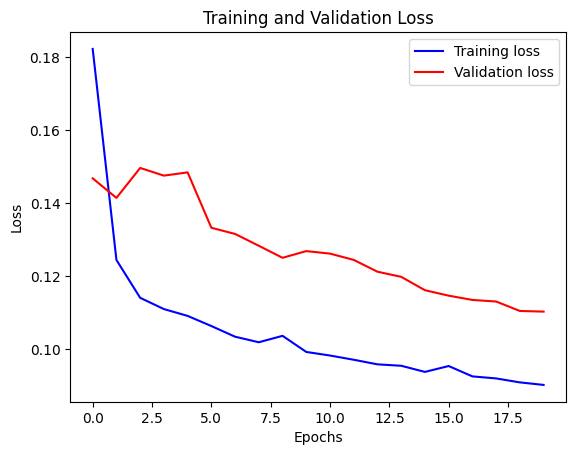

In [37]:
# ロスを表示する関数を定義する
def visualize_loss(history, title):
    # history 内にある訓練データのロス情報を変数 loss に代入
    loss = history.history["loss"]
    # history 内にある検証データのロス情報を変数 val_loss に代入
    val_loss = history.history["val_loss"]
    # lossの数の範囲を epochs に代入
    epochs = range(len(loss))
    plt.figure()
    # x軸をエポックス数、y軸をロスでグラフを描く
    # 訓練データ、検証データ、それぞれで
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# 上で定義した関数を実行する
visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

In [ ]:
# 時系列データと予測値のグラフを描く関数を定義
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

8/8 [==============================] - 0s 4ms/step


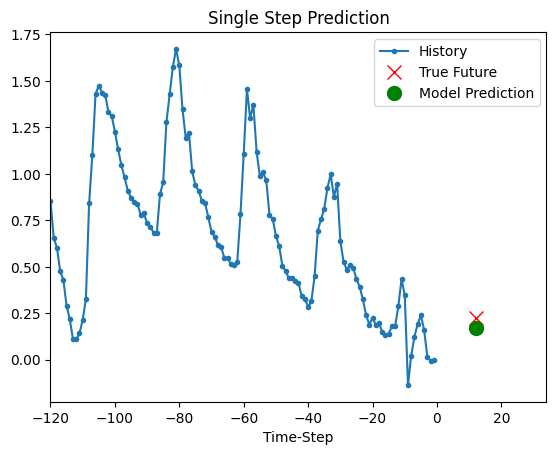

8/8 [==============================] - 0s 4ms/step


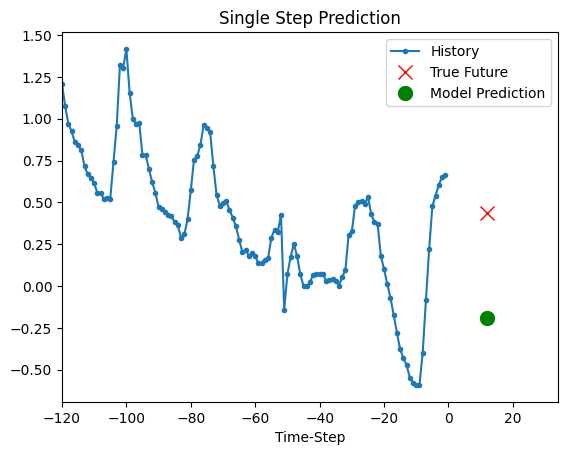

8/8 [==============================] - 0s 4ms/step


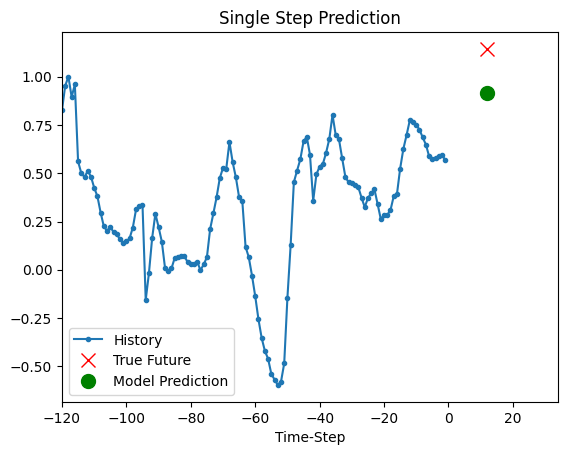

8/8 [==============================] - 0s 4ms/step


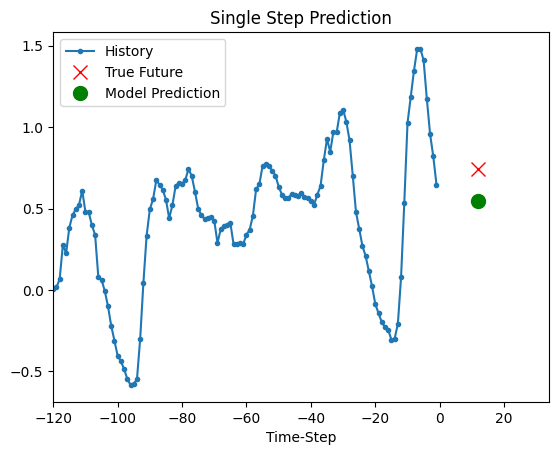

8/8 [==============================] - 0s 5ms/step


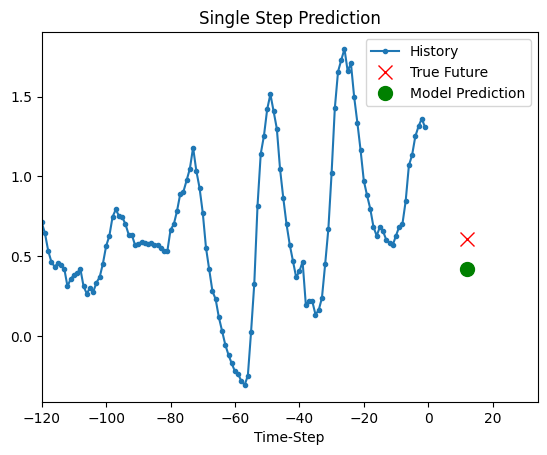

8/8 [==============================] - 0s 5ms/step


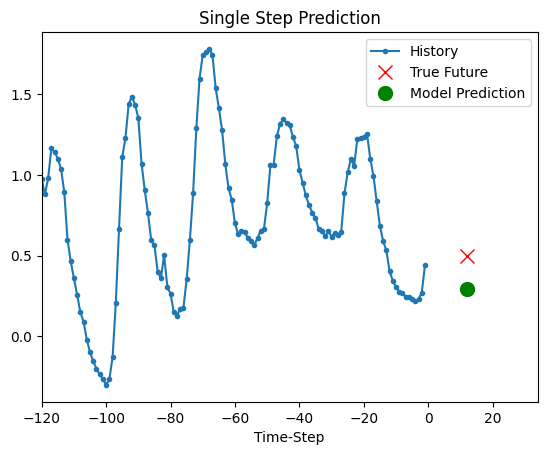

8/8 [==============================] - 0s 5ms/step


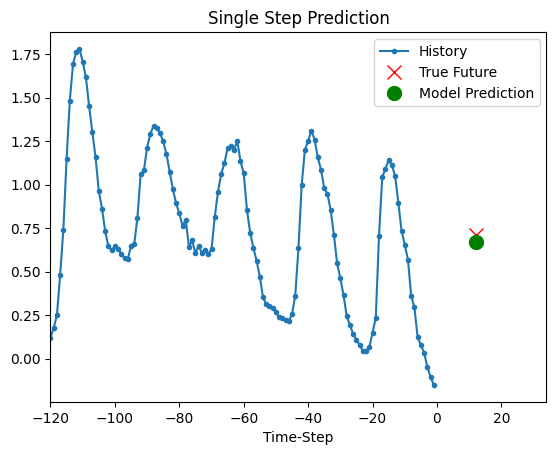

8/8 [==============================] - 0s 6ms/step


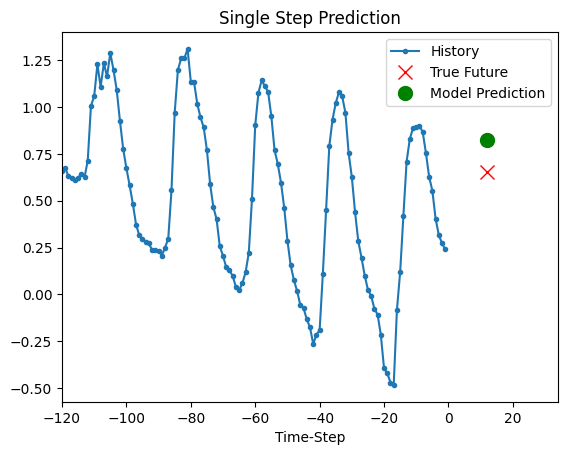

8/8 [==============================] - 0s 5ms/step


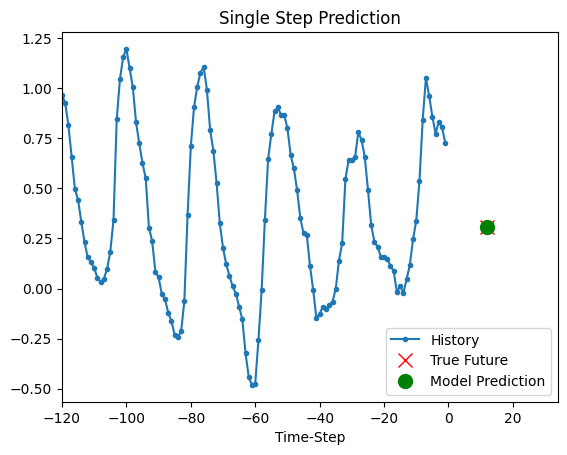

8/8 [==============================] - 0s 5ms/step


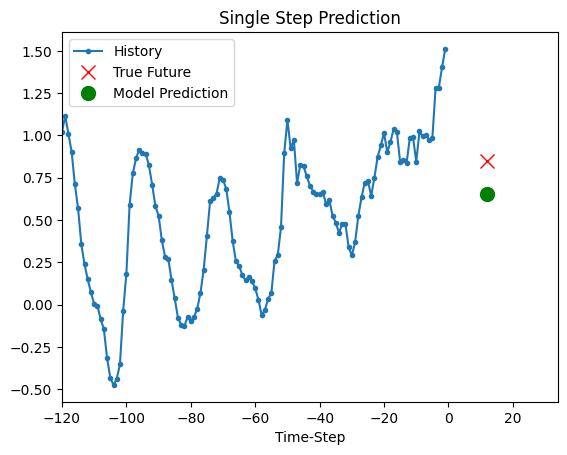

In [39]:
# 上で定義した関数で　10種類の検証データへ適用した結果を表示

for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Time%20Series-black.svg)](https://huggingface.co/keras-io/timeseries_forecasting_for_weather) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Time%20Series-black.svg)](https://huggingface.co/spaces/keras-io/timeseries_forecasting_for_weather) |